# African Jets
This tutorial creates a representation of the African Jets over the Sahel. 

These jets are: 
 * Tropcial Easterly Jet (at around 200 hPa)
 * African Easterly Jet (at around 600 hPa)
 * African Easterly Waves (between)


In [37]:
import numpy as np
import geoutils.plotting.plots as gplt
import geoutils.geodata.base_dataset as bds
import geoutils.utils.time_utils as tu
import geoutils.tsa.time_series_analysis as tsa
import geoutils.tsa.propagation as prop
import geoutils.tsa.pca.eof as eof
import geoutils.tsa.pca.multivariate_pca as mvpca
import geoutils.utils.general_utils as gut
import geoutils.geodata.wind_dataset as wds
import geoutils.utils.met_utils as mut
import geoutils.utils.spatial_utils as sput

from importlib import reload
output_dir = "/home/strnad/data/"
data_dir = "/home/strnad/data/"
plot_dir = "/home/strnad/data/plots/african_jets/"

In [31]:
# Load data
grid_step = 2.5
# Load wind fields
reload(wds)
nc_files_u = []
nc_files_v = []
nc_files_w = []
levs = [200, 600]
levs = np.arange(100, 1050, 100)
for lev in levs:
    dataset_file_u = data_dir + \
        f"/climate_data/{grid_step}/era5_u_{grid_step}_{lev}_ds.nc"
    nc_files_u.append(dataset_file_u)
    dataset_file_v = data_dir + \
        f"/climate_data/{grid_step}/era5_v_{grid_step}_{lev}_ds.nc"
    nc_files_v.append(dataset_file_v)
    dataset_file_w = data_dir + \
        f"/climate_data/{grid_step}/era5_w_{grid_step}_{lev}_ds.nc"
    nc_files_w.append(dataset_file_w)

reload(wds)
ds_wind = wds.Wind_Dataset(data_nc_u=nc_files_u,
                        #    data_nc_v=nc_files_v,
                           #    data_nc_w=nc_files_w,
                           plevels=levs,
                           can=True,
                           an_types=['month'],
                           month_range=['Jul', 'Aug'],
                           init_mask=False,
                           grid_step=grid_step,
                           verbose=False
                           )

Load time_range:(<xarray.DataArray ()>
array('1979-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1979-01-01, <xarray.DataArray ()>
array('2019-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-12-31)
All wind files are available! Now load them!
('All files are available! Loading '
 "['/home/strnad/data//climate_data/2.5/era5_u_2.5_100_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.5_200_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.5_300_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.5_400_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.5_500_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.5_600_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.5_700_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.5_800_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.5_900_ds.nc', "
 "'/home/strnad/data//climate_data/2.5/era5_u_2.

In [10]:
dataset_file = data_dir + \
    f"climate_data/{grid_step}/era5_ttr_{grid_step}_ds.nc"

ds_olr = bds.BaseDataset(data_nc=dataset_file,
                         can=True,
                         month_range=['Jun', 'Sep'],
                         an_types=['month', 'JJAS'],
                         verbose=False
                         )

File location: /home/strnad/data/climate_data/2.5/era5_ttr_2.5_ds.nc
File size: 600.62 MB
Start processing data!
3d object transposed to lat-lon-time!
Sorted longitudes and latitudes in ascending order!
Set time to np.datetime[ns] time format!
set hours to 0
Rename top net thermal radiation (ttr) to: olr [W/m2]!
Multiply by -1/3600!
End processing data! Dimensions: ['time', 'lat', 'lon']
Load data from in time range (numpy.datetime64('1979-01-01'), numpy.datetime64('2019-12-31'))!
Select data from Jun - Sep!
Different grid step in lon 2.52 and lat 2.5 direction!
Finished processing data
Set variable name to olr!
Created monthly anomalies!
Rename olr to olr_an_month!
Created JJASly anomalies!
Rename olr to olr_an_JJAS!
No mask initialized!
Set dataset source attributes!


In [48]:
reload(mut)
sahel_lon_range = [-10, 10]  # Along this line is the vertical cross section
sahel_lat_range = [-10, 30]

var_name = 'u'
cross_data_av = mut.vertical_cross_section_average(ds_wind.ds[var_name],
                                                   lon_range=sahel_lon_range,
                                                   lat_range=sahel_lat_range,)
cross_data_av

<xarray.DataArray 'u' (time: 2542, lev: 10, lat: 17)>
array([[[-9.92548275e+00, -1.20762959e+01, -1.40185747e+01, ...,
         -2.32246494e+00,  2.26238155e+00,  6.14063549e+00],
        [ 4.37830877e+00,  4.75660896e+00, -5.14582932e-01, ...,
          6.08889437e+00,  1.14627495e+01,  2.12602997e+01],
        [-7.80581856e+00,  9.75177109e-01,  1.27137887e+00, ...,
          8.43620777e+00,  1.21673260e+01,  1.72205143e+01],
        ...,
        [-4.44975471e+00, -4.72187138e+00, -4.67202139e+00, ...,
          4.49220848e+00,  5.19650078e+00,  8.58281374e-01],
        [-4.98742771e+00, -5.84556293e+00, -5.01240110e+00, ...,
          3.27966523e+00,  3.12195873e+00, -1.67351449e+00],
        [-2.44678831e+00, -2.30508327e+00, -2.00470614e+00, ...,
          1.76651061e+00,  2.05626011e+00, -1.14832354e+00]],

       [[-1.41546068e+01, -1.53284626e+01, -1.72246704e+01, ...,
         -1.32052994e+00,  2.63919783e+00,  6.27860785e+00],
        [-2.23944977e-01,  4.40507746e+00,  3.04661179e+00, ...,
          6.96669054e+00,  1.29971285e+01,  2.28588104e+01],
        [-3.28783894e+00,  3.66567564e+00,  2.15215731e+00, ...,
          6.47296953e+00,  1.02555609e+01,  2.05332184e+01],
...
         -3.26862907e+00, -1.92704344e+00,  1.84655786e+00],
        [-3.51199603e+00, -2.15326405e+00, -1.45699644e+00, ...,
         -1.12102389e+00, -3.92155290e+00, -1.77050245e+00],
        [-1.13894975e+00, -1.64311576e+00, -1.84222496e+00, ...,
         -2.33198047e+00, -2.94412398e+00, -2.34535858e-01]],

       [[ 9.76221275e+00,  9.31289864e+00,  9.14099884e+00, ...,
         -2.40787959e+00,  1.19017887e+00,  4.26376295e+00],
        [-3.73515034e+00, -5.65098763e+00, -6.37343168e+00, ...,
          2.92126465e+00,  8.93949509e+00,  1.88835888e+01],
        [-6.93564606e+00, -9.23130131e+00, -1.01805792e+01, ...,
          2.34828889e-01,  6.37727261e+00,  1.51803627e+01],
        ...,
        [-5.26908398e-01, -4.94807243e-01, -1.12350512e+00, ...,
         -9.72286642e-01,  4.72265124e-01,  5.61026621e+00],
        [-3.07420063e+00, -1.00786495e+00, -5.18883877e-02, ...,
          2.21080519e-02, -3.63690352e+00,  1.50306761e+00],
        [-3.15722048e-01,  1.44236422e+00,  1.53532255e+00, ...,
         -3.88992578e-01, -1.39833951e+00,  3.44948888e+00]]],
      dtype=float32)
Coordinates:
  * lev        (lev) int64 100 200 300 400 500 600 700 800 900 1000
  * time       (time) datetime64[ns] 1979-07-01 1979-07-02 ... 2019-08-31
  * lat        (lat) float64 -10.0 -7.5 -5.0 -2.5 0.0 ... 22.5 25.0 27.5 30.0
    metpy_crs  object Projection: latitude_longitude
    month      (time) int64 7 7 7 7 7 7 7 7 7 7 7 7 ... 8 8 8 8 8 8 8 8 8 8 8 8

In [44]:
cross_data_line = mut.vertical_cross_section(data=ds_wind.ds[var_name],
                                        lon_range=sahel_lon_range,
                                        lat_range=sahel_lat_range)

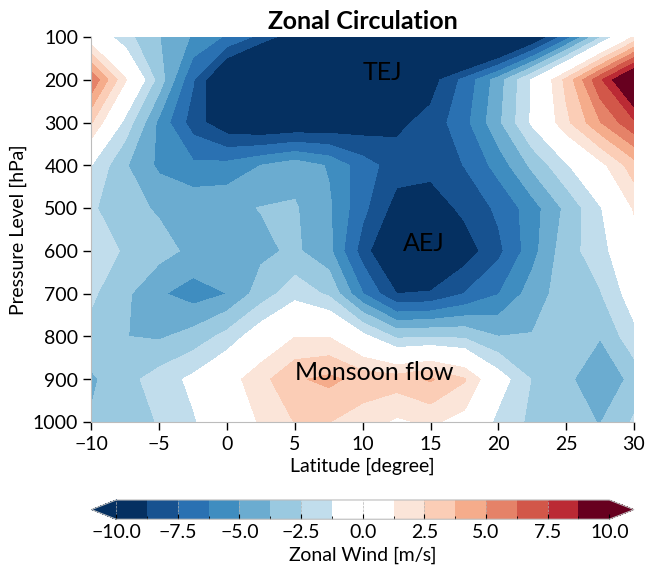

In [87]:
reload(gplt)
lats = cross_data_av['lat']
plevels = cross_data_av.lev
label_u = 'Zonal Wind [m/s]'
h_im_u = gplt.plot_2D(x=lats, y=plevels,
                      z=cross_data_av.mean(dim='time'),
                      levels=16,
                      title='Zonal Circulation',
                      cmap='RdBu_r',
                      centercolor='white',
                      plot_type='contourf',
                      extend='both',
                      xlabel='Latitude [degree]',
                      ylabel='Pressure Level [hPa]',
                      flip_y=True,
                      label=label_u,
                      vmin=-10, vmax=10,
                      pad=-5,
                      ylim=[100, 1000],
                      )

gplt.plt_text(ax=h_im_u['ax'],
              text='TEJ',
              xpos=10,
              ypos=200)
_= gplt.plt_text(ax=h_im_u['ax'],
              text='AEJ',
              xpos=13,
              ypos=600)
_= gplt.plt_text(ax=h_im_u['ax'],
              text='Monsoon flow',
              xpos=5,
              ypos=900)

## PCA of Jets in Africa

In [80]:
input_data = cross_data_av
dims = gut.get_dims(input_data)
dims.remove('time')
dims

['lev', 'lat']

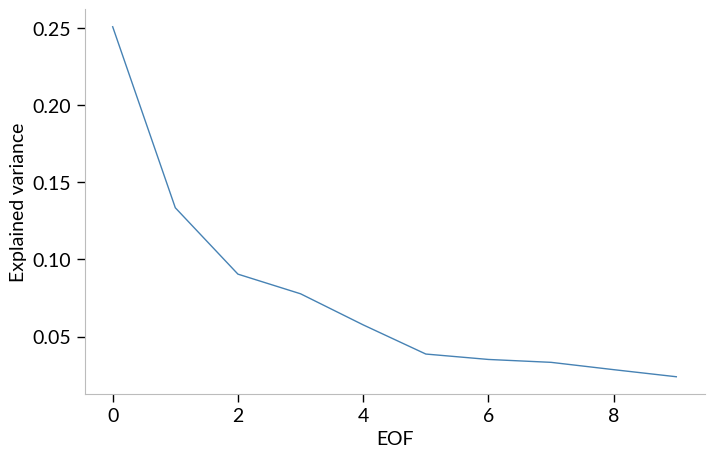

In [88]:
reload(eof)
sppca = eof.SpatioTemporalPCA(input_data, n_components=10)
eofs = sppca.get_eofs()
pcs = sppca.get_principal_components()
im = gplt.plot_xy(y_arr=sppca.explained_variance(),
                 xlabel='EOF', ylabel='Explained variance', ylog=False)

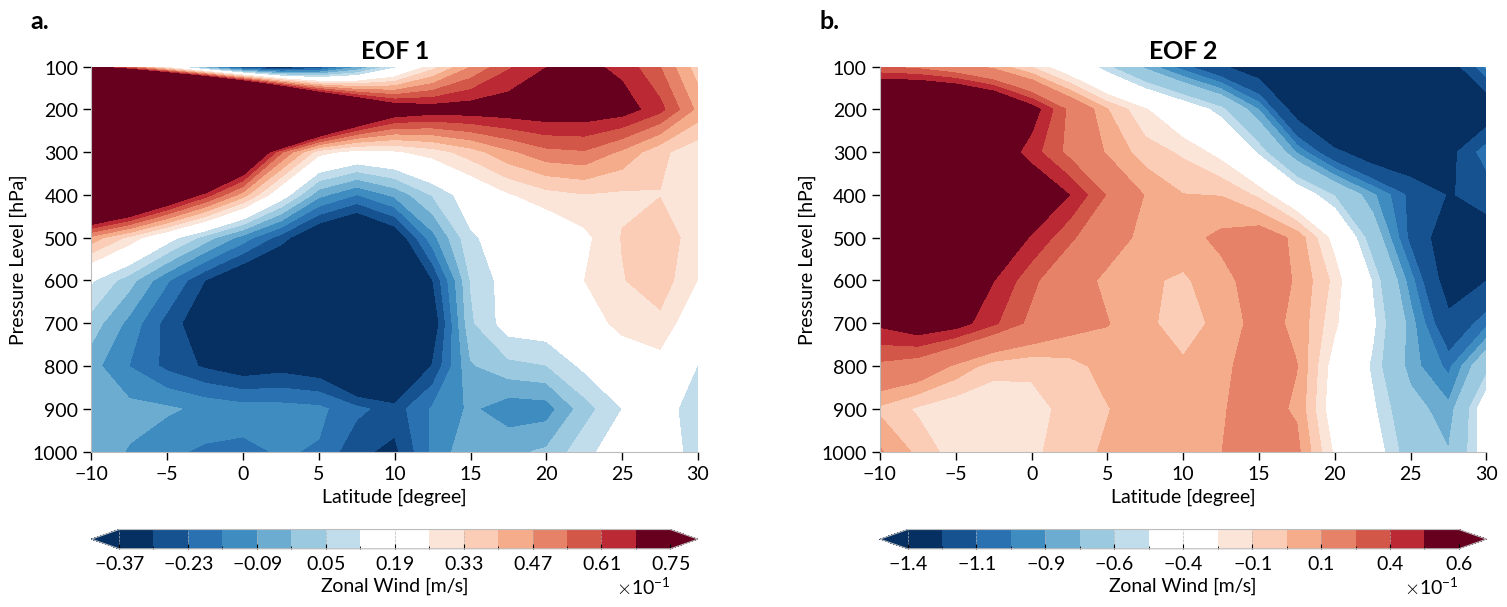

In [104]:
reload(gplt)
i = 0
ncols = 2
im = gplt.create_multi_plot(nrows=1, ncols=ncols,
                            wspace=0.3,
                            )

for i in range(2):
    im_eof = gplt.plot_2D(x=lats, y=plevels,
                       ax=im['ax'][i],
                      z=eofs.isel(eof=i),
                      levels=16,
                      title=f'EOF {i+1}',
                      cmap='RdBu_r',
                      centercolor='white',
                      plot_type='contourf',
                      extend='both',
                      xlabel='Latitude [degree]',
                      ylabel='Pressure Level [hPa]',
                      flip_y=True,
                      label=label_u,
                    #   vmin=-10, vmax=10,
                      pad=-5,
                      ylim=[100, 1000],
                      )